In [ ]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Some explorative data analysis

In [ ]:
!mkdir data
!cp '/content/drive/My Drive/pred-analit/GC-predictive-analytics-worksheet - Sheet1.csv' data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
df = pd.read_csv('data/GC-predictive-analytics-worksheet - Sheet1.csv')

In [ ]:
df.head

<bound method NDFrame.head of    cluster  Gender  Age  ...         ER.13    15         ER.14
0        0  Female   44  ...             0   Phy             0
1        1    Male   40  ...             0  diet             0
2        1  Female   37  ...  0.8571428571  diet  0.4285714286
3        2    Male   34  ...             0   Phy             0
4        2  Female   60  ...       #DIV/0!   NaN       #DIV/0!
5        9  Female   63  ...             0   Phy             0
6        9  Female   49  ...             0   Phy             0
7        0  Female   62  ...       #DIV/0!   NaN             0
8        1    Male   81  ...             0  diet             0
9        9  Female   62  ...  0.2857142857  diet             1

[10 rows x 43 columns]>

In [ ]:
df.columns

Index(['cluster', 'Gender', 'Age', 'Ethnicity', 'Income', 'Work hours',
       'Health condition', 'Education', 'Motivation', 'Attitude', 'Intention',
       'Ownership', 'Unnamed: 12', '1', 'ER', '2', 'ER.1', '3', 'ER.2', '4',
       'ER.3', '5', 'ER.4', '6', 'ER.5', '7', 'ER.6', '8', 'ER.7', '9', 'ER.8',
       '10', 'ER.9', '11', 'ER.10', '12', 'ER.11', '13', 'ER.12', '14',
       'ER.13', '15', 'ER.14'],
      dtype='object')

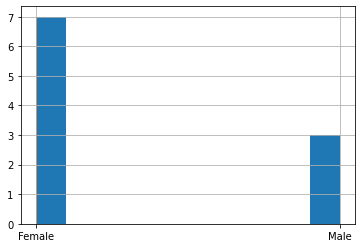

In [ ]:
df.Gender.hist()

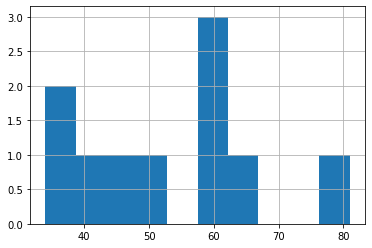

In [ ]:
df.Age.hist()

In [ ]:
del df['Unnamed: 12']

In [ ]:
data = defaultdict(list)
y = []

In [ ]:
rec_idxs = [str(i) for i in range(1, 16)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 15)])

In [ ]:
for i in range(len(df)):
  for rec, er in zip(rec_idxs, er_idxs):
    data['gender'].append(df.Gender[i])
    data['age'].append(df.Age[i])
    data['health'].append(df['Health condition'][i])
    data['hours'].append(df['Work hours'][i])
    data['motivation'].append(df['Motivation'][i])
    data['attitute'].append(df['Attitude'][i])
    data['intention'].append(df['Intention'][i])
    data['ownership'].append(df['Ownership'][i])
    data['rec'].append(df[rec][i])
    try:
      data['y'].append(float(df[er][i]))
    except ValueError:
      data['y'].append('NaN')

In [ ]:
len(data['age']), len(data['y'])

(150, 150)

In [ ]:
df = pd.DataFrame(data)
df = df.dropna()

In [ ]:
df.head()

,gender,age,health,hours,motivation,attitute,intention,ownership,rec,y
0,Female,44,Good,50+ hrs/week,0.265623,0.52659,0.507169,0.559363,Phy,0.166667
1,Female,44,Good,50+ hrs/week,0.265623,0.52659,0.507169,0.559363,diet,0.714286
2,Female,44,Good,50+ hrs/week,0.265623,0.52659,0.507169,0.559363,diet,0.428571
3,Female,44,Good,50+ hrs/week,0.265623,0.52659,0.507169,0.559363,diet,0.571429
4,Female,44,Good,50+ hrs/week,0.265623,0.52659,0.507169,0.559363,diet,0.75


In [ ]:
y = df.y.values
X = df[df.columns.difference(['y'])]

In [ ]:
continuous_features = list(X.select_dtypes(include = ['float', 'int']).columns)
categorical_features = list(X.select_dtypes(exclude = ['float', 'int']).columns)
print('Continuous: {}'.format(continuous_features))
print('Categorical: {}'.format(categorical_features))

Continuous: ['age', 'attitute', 'intention', 'motivation', 'ownership']
Categorical: ['gender', 'health', 'hours', 'rec']


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, shuffle=True)

In [ ]:
transformer_scaled = ColumnTransformer([
    ('continuous', StandardScaler(), continuous_features),
    ('categorical', Pipeline([('encode', OneHotEncoder(drop='first')), 
                              ('scale', StandardScaler(with_mean=False))]), categorical_features), 
])
transformer_scaled.fit(X)
X_transformed = transformer_scaled.transform(X)
#X_train_transformed = transformer.transform(X_train)
#X_test_transformed = transformer.transform(X_test)
#X_train_transformed_scaled = transformer_scaled.transform(X_train)
#X_test_transformed_scaled = transformer_scaled.transform(X_test)

In [ ]:
X_transformed

array([[-0.31948979, -1.14479884, -1.65886817, ...,  0.        ,
         2.00621494,  0.        ],
       [-0.31948979, -1.14479884, -1.65886817, ...,  0.        ,
         2.00621494,  2.25334509],
       [-0.31948979, -1.14479884, -1.65886817, ...,  0.        ,
         2.00621494,  2.25334509],
       ...,
       [ 0.76949457, -0.92502109, -0.30251053, ...,  0.        ,
         0.        ,  2.25334509],
       [ 0.76949457, -0.92502109, -0.30251053, ...,  0.        ,
         0.        ,  2.25334509],
       [ 0.76949457, -0.92502109, -0.30251053, ...,  0.        ,
         0.        ,  2.25334509]])

(array([56.,  3.,  3.,  0.,  5.,  4.,  0.,  2.,  7.,  9.]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <a list of 10 Patch objects>)

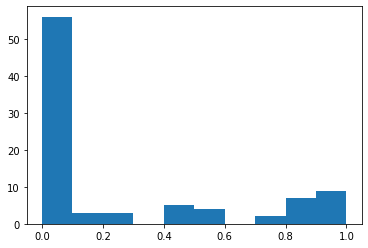

In [ ]:
plt.hist(y)

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X_transformed, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.521 ([0.64477451 0.4748065  0.10300761 0.55684402 0.82396794])
Ridge: 0.656 ([0.84099333 0.67336083 0.64059126 0.30155058 0.82283955])
Lasso: -0.148 ([-1.10065669e-01 -2.73390050e-01 -1.49716920e-01 -3.24429117e-05
 -2.07216140e-01])
Elastic: -0.037 ([-0.01243707 -0.02743477 -0.10645267 -0.03803875 -0.00181142])


In [ ]:
X.shape

(89, 9)

# MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras import models 
from tensorflow.keras import layers

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Dense(12, activation='relu', input_shape=(12, )))
mlp.add(layers.Dropout(0.25))
mlp.add(layers.Dense(12, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_transformed.shape
X_transformed.dtype
type(X_transformed)

numpy.ndarray

In [ ]:
y = y.reshape(-1, 1).astype('float32')
X_transformed = X_transformed.astype('float32')
print(y.shape)
print(X_transformed.shape)

(89, 1)
(89, 12)


In [ ]:
mlp.fit(X_transformed, y, batch_size=4, epochs=1000, validation_split=0.25)

Epoch 1/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.1374 - mse: 0.1374 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 2/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0959 - mse: 0.0959 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 3/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.0609 - val_mse: 0.0609
Epoch 4/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0933 - mse: 0.0933 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 5/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0718 - mse: 0.0718 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 6/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.1285 - mse: 0.1285 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 7/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0901 - mse: 0.0901 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 8/1000
17/17 [==============================] - 0s 2ms/step - loss: 0

In [ ]:
mlp.predict(X_transformed)

array([[6.2587500e-02],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.3944167e-01],
       [6.2587500e-02],
       [6.2587500e-02],
       [6.2587500e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [6.0225457e-02],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.7135491e-01],
       [7.713549

# Time series

In [ ]:
df = pd.read_csv('data/GC-predictive-analytics-worksheet - Sheet1.csv')

In [ ]:
rec_idxs = [str(i) for i in range(1, 16)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 15)])

In [ ]:
rrecs = []
eers = []
iids = []
for i in range(len(df)):
  recs = []
  ers = []
  for rec, er in zip(rec_idxs, er_idxs):
      recomendation = df[rec][i]
      try:
        engagement = float(df[er][i])
      except ValueError:
        engagement = 0.0
      if pd.isna(recomendation):
        continue
      elif recomendation == 'Phy':
        recomendation = 0
      else:
        recomendation = 1
      recs.append(recomendation)
      ers.append(engagement)
  rrecs.append(recs)
  eers.append(ers)
  gender = df.Gender[i]
  hours = df['Work hours'][i]
  hmap = {'1-15 hrs/week': 0.2, '16-35 hrs/week': 0.4, '36-50 hrs/week': 0.6, '50+ hrs/week': 1.0}
  if hours in hmap:
    hours = hmap[hours]
  else:
    hours = 0.0
  if gender == 'Female':
    gender = 0
  else:
    gender = 1
  motivation = df.Motivation[i]	
  if pd.isna(motivation):
    motivation = 0.0
  attitude = df.Attitude[i]
  if pd.isna(attitude):
    attitude = 0
  intention = df.Intention[i]
  if pd.isna(intention):
    intention = 0
  ownership = df.Ownership[i]
  if pd.isna(ownership):
    ownership = 0
  iids.append(dict(age = df.Age[i] / 82,
                   gender = gender,  
                   motivation = motivation,	
                   attitude = attitude, 
                   intention = intention,
                   ownership = ownership,
                   hours = hours))

In [ ]:
rrecs, eers

([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  [],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1]],
 [[0.1666666667,
   0.7142857143,
   0.4285714286,
   0.5714285714,
   0.75,
   0.4285714286,
   0.8571428571,
   1.0,
   1.0,
   0.2857142857,
   0.5714285714,
   0.5,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.2857142857,
   0.0,
   0.125,
   0.4285714286,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.4285714286,
   1.0,
   0.8571428571,
   0.875,
   0.8571428571,
   1.0,
   1.0,
   1.0,
   0.8571428571,
   0.8571428571,
   1.0,
   1.0,
   0.8571428571,
   0.4285714286],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [

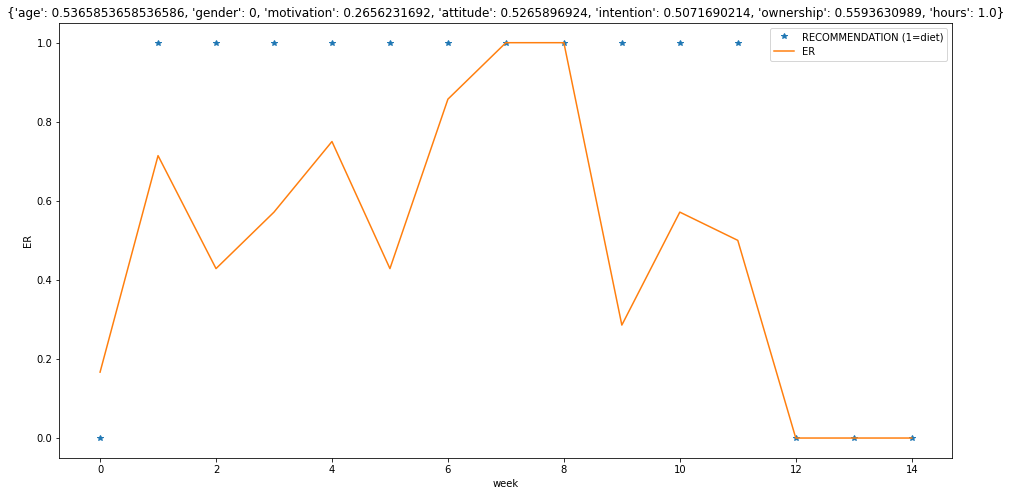

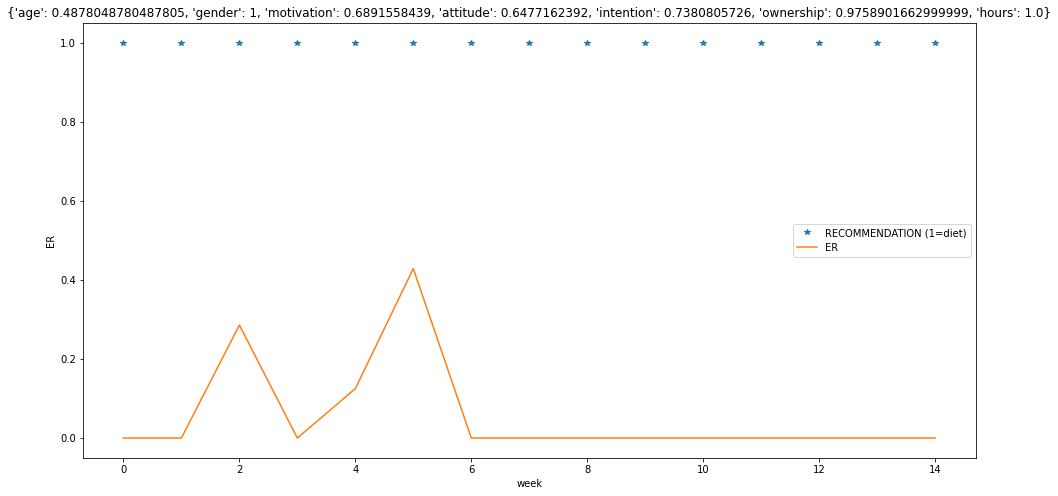

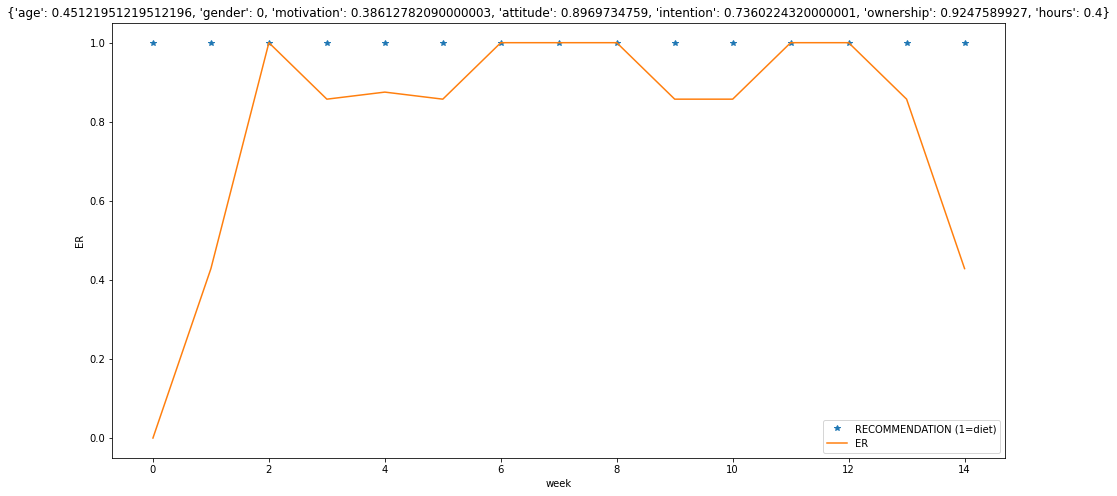

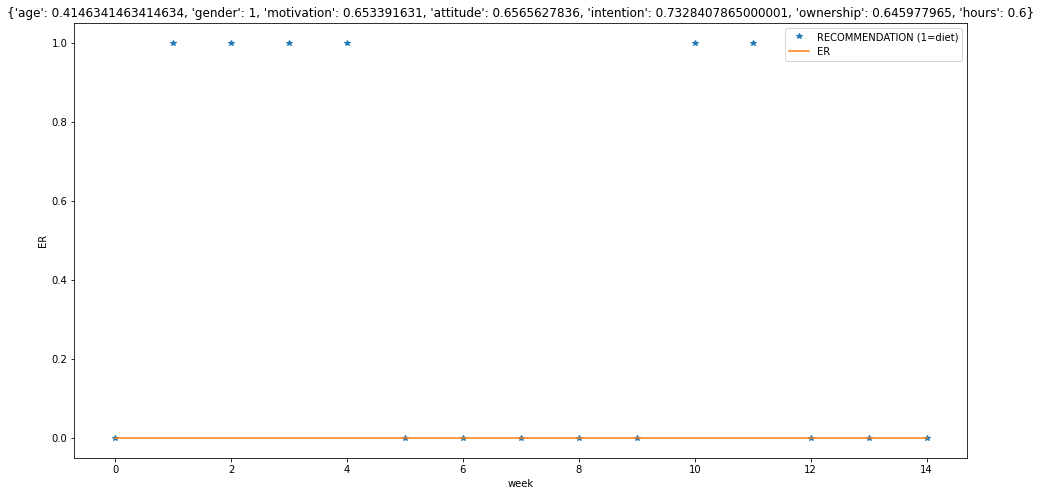

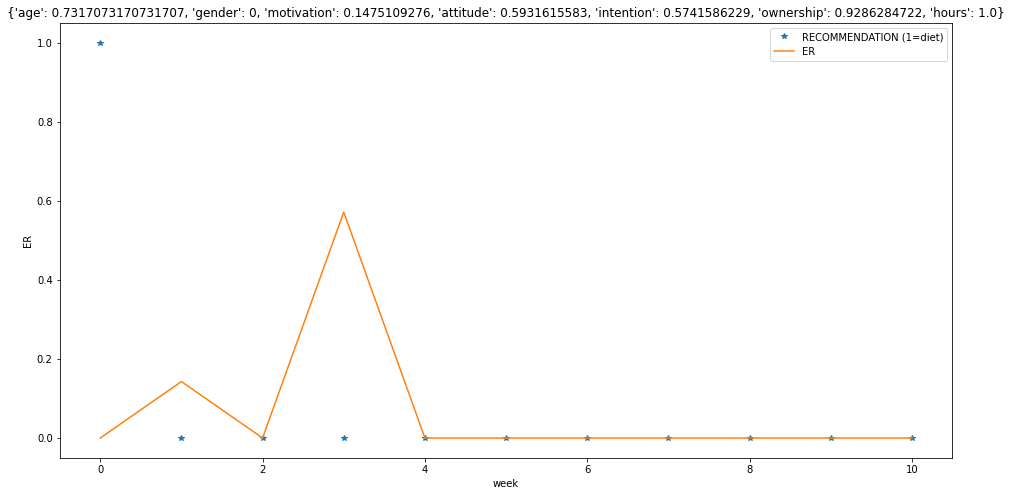

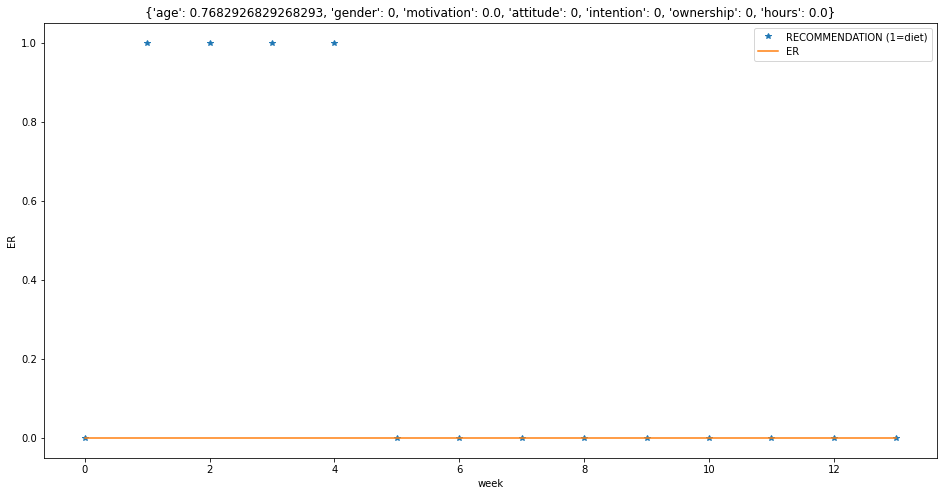

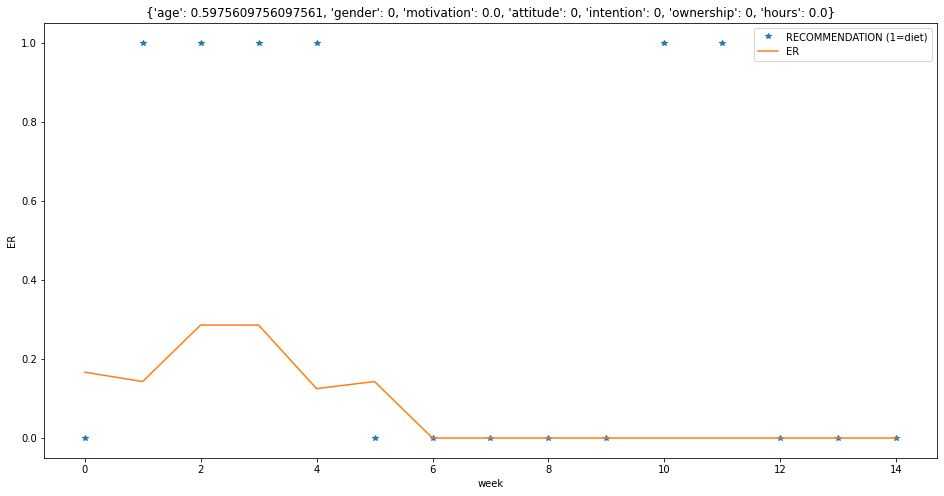

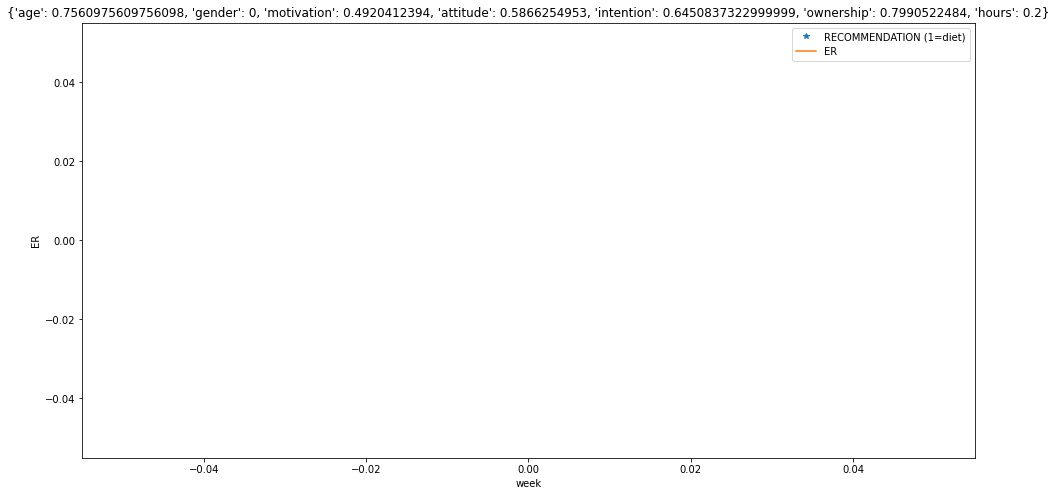

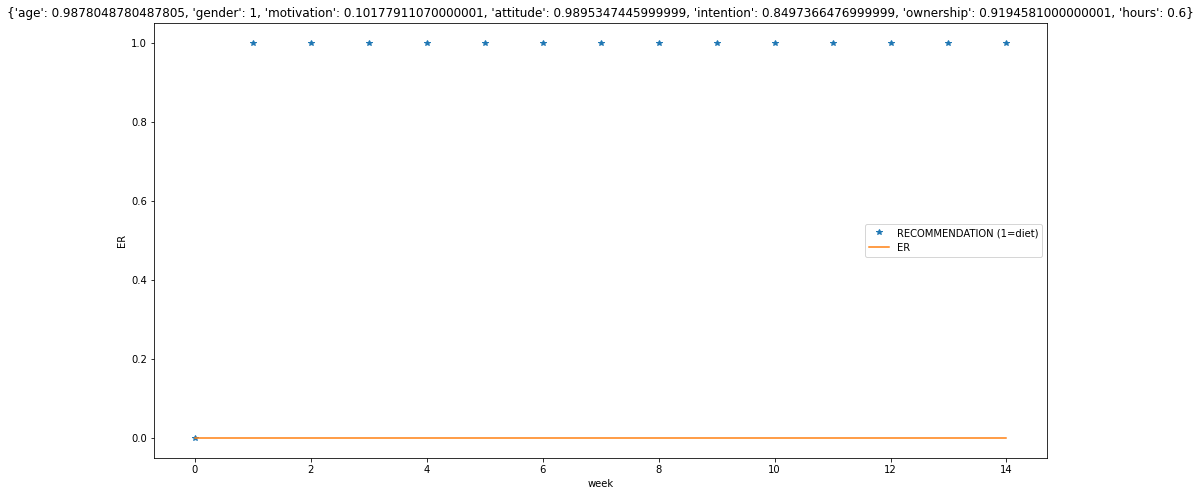

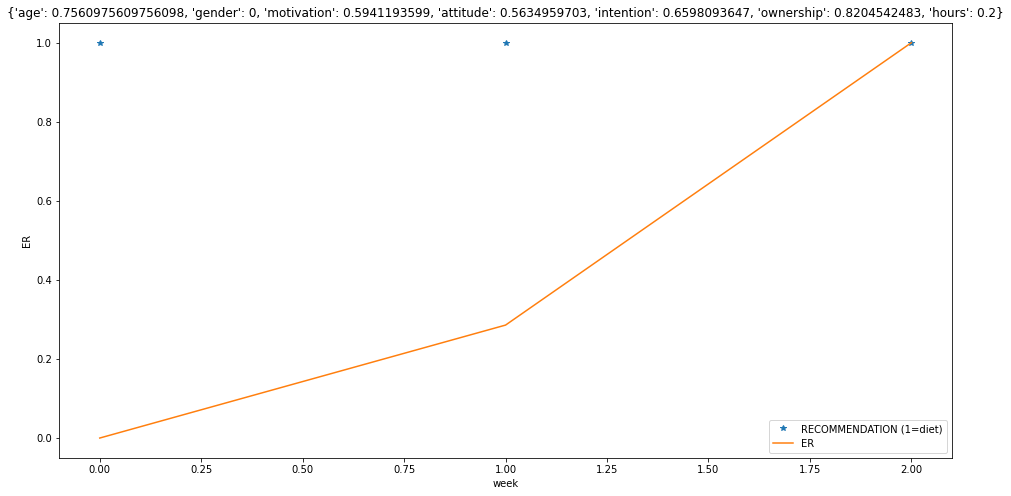

In [ ]:
for i in range(len(rrecs)):
  plt.figure(figsize=(16, 8))
  plt.plot(list(range(len(rrecs[i]))), rrecs[i], '*', list(range(len(rrecs[i]))), eers[i])
  plt.legend(['RECOMMENDATION (1=diet)', 'ER'])
  plt.xlabel('week')
  plt.ylabel('ER')
  plt.title('{}'.format(repr(iids[i])))
  plt.show()

In [ ]:
X = []
y = []
for i in range(len(rrecs)):
  for j in range(len(rrecs[i]) - 2):
    r1 = rrecs[i][j]
    r2 = rrecs[i][j+1]
    # X.append([eers[i][j], r2 - r1, r1, r2, iids[i]['age']])
    X.append([eers[i][j], r1, r2, r2-r1, iids[i]['age'], iids[i]['motivation']]) #iids[i]['attitude']])
    y.append(eers[i][j+1])

In [ ]:
for i in range(20):
  print(X[i], y[i])

[0.1666666667, 0, 1, 1, 0.5365853658536586, 0.2656231692] 0.7142857143
[0.7142857143, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.4285714286
[0.4285714286, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.5714285714
[0.5714285714, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.75
[0.75, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.4285714286
[0.4285714286, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.8571428571
[0.8571428571, 1, 1, 0, 0.5365853658536586, 0.2656231692] 1.0
[1.0, 1, 1, 0, 0.5365853658536586, 0.2656231692] 1.0
[1.0, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.2857142857
[0.2857142857, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.5714285714
[0.5714285714, 1, 1, 0, 0.5365853658536586, 0.2656231692] 0.5
[0.5, 1, 0, -1, 0.5365853658536586, 0.2656231692] 0.0
[0.0, 0, 0, 0, 0.5365853658536586, 0.2656231692] 0.0
[0.0, 1, 1, 0, 0.4878048780487805, 0.6891558439] 0.0
[0.0, 1, 1, 0, 0.4878048780487805, 0.6891558439] 0.2857142857
[0.2857142857, 1, 1, 0, 0.4878048780487805, 0.6891558439] 

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.476 ([ 0.71428774  0.72727975  0.73788118  0.91079723 -0.71213422])
Ridge: 0.691 ([0.81006208 0.38578618 0.62942285 0.8666001  0.7613313 ])
Lasso: -0.214 ([-0.01032648 -0.04576936 -0.9480618  -0.0546272  -0.00993228])
Elastic: -0.017 ([-0.00462334 -0.02550677 -0.00067985 -0.01175504 -0.04194674])


In [ ]:
poly = PolynomialFeatures(2)
X_ = poly.fit_transform(X)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X_, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.764 ([0.88938003 0.70452757 0.82592265 0.76570691 0.63492309])
Ridge: 0.725 ([0.87897261 0.6845238  0.43574808 0.8658984  0.76090095])
Lasso: -0.076 ([-2.01906194e-01 -2.56875647e-02 -3.49906785e-03 -1.08026824e-05
 -1.48257589e-01])
Elastic: -0.570 ([-0.08405848 -0.0731324  -2.57472017 -0.01387967 -0.10561995])


In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)